In [2]:
!pip install -q gradio
!pip install beautifulsoup4
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

In [14]:
##imports 
import requests
import gradio as gr
import os, json, pickle, random, torch
import shutil
import torch.utils.data
from PIL import Image
import clip
import math
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import requests
import urllib
import sys

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

# Encode all the food categories to be used by the model
# Load all food categories
cats = ['Apple pie', 'Baby back ribs', 'Baklava', 'Beef carpaccio', 'Beef tartare', 
        'Beet salad', 'Beignets', 'Bibimbap', 'Bread pudding', 'Breakfast burrito', 
        'Bruschetta', 'Caesar salad', 'Cannoli', 'Caprese salad', 'Carrot cake', 'Ceviche', 
        'Cheese plate', 'Cheesecake', 'Chicken curry', 'Chicken quesadilla', 'Chicken wings', 
        'Chocolate cake', 'Chocolate mousse', 'Churros', 'Clam chowder', 'Club sandwich', 
        'Crab cakes', 'Creme brulee', 'Croque madame', 'Cup cakes', 'Deviled eggs', 'Donuts', 
        'Dumplings', 'Edamame', 'Eggs benedict', 'Escargots', 'Falafel', 'Filet mignon', 
        'Fish and chips', 'Foie gras', 'French fries', 'French onion soup', 'French toast', 
        'Fried calamari', 'Fried rice', 'Frozen yogurt', 'Garlic bread', 'Gnocchi', 'Greek salad', 
        'Grilled cheese sandwich', 'Grilled salmon', 'Guacamole', 'Gyoza', 'Hamburger', 
        'Hot and sour soup', 'Hot dog', 'Huevos rancheros', 'Hummus', 'Ice cream', 'Lasagna', 
        'Lobster bisque', 'Lobster roll sandwich', 'Macaroni and cheese', 'Macarons', 'Miso soup', 
        'Mussels', 'Nachos', 'Omelette', 'Onion rings', 'Oysters', 'Pad thai', 'Paella', 
        'Pancakes', 'Panna cotta', 'Peking duck', 'Pho', 'Pizza', 'Pork chop', 'Poutine', 
        'Prime rib', 'Pulled pork sandwich', 'Ramen', 'Ravioli', 'Red velvet cake', 'Risotto', 
        'Samosa', 'Sashimi', 'Scallops', 'Seaweed salad', 'Shrimp and grits', 'Spaghetti bolognese', 
        'Spaghetti carbonara', 'Spring rolls', 'Steak', 'Strawberry shortcake', 'Sushi', 'Tacos', 
        'Takoyaki', 'Tiramisu', 'Tuna tartare', 'Waffles']
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

100%|███████████████████████████████████████| 890M/890M [02:28<00:00, 6.29MiB/s]


In [47]:
def predict_food(image, cats, model, preprocess, text_features):
    """
    Predicts the top 3 classification predictions for an input image
        Input:  img: RGB PIL.Image.Image file
                cats: Food categories (From previous cell)
                model: CLIP model (From previous cell)
                preprocess: CLIP model preprocessing tools (From previous cell)
                text_features: Encoded output categories to be used as predictors (From previous cell)
                
        Output: List of top 3 food class predictions (ordered)
    """
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    
    with torch.no_grad():
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)
        
    # Compute the predictions
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    score, pred_id = similarity[0].topk(3)
    
    predictions = [cats[idx] for idx in list(pred_id)]
    score.tolist()
    output = []
    for i in range(len(score)):
        output.append((predictions[i], round(float(score[i]), 3)))
    return output


def findRecipe(foods):
    """
    Function which takes input of list of tuples.
    Tuples consists of name of food (string), and its proability (float). 
    Outputs dictionary for recipes for top 3 foods and ingredients.
    """
    
    print('Does this food have a main ingredient? (ie. input "Chicken" for Chicken burrito)')
    added = input('input "no" if it does not have one')
    if added == 'no':
        extra = ""
    else:
        extra = added
    outputs = {}
    for food in foods:
        
        output = []
        food_name, food_prob = food
        
        ##get top hit from allrecipes.com using food as query 
        query = extra + food_name 
        query = urllib.parse.quote_plus(query)

        r = requests.get('https://www.allrecipes.com/search/results/?search={}'.format(query))
        soup = BeautifulSoup(r.text, "html.parser")

        for item in soup.find_all('a', href=True):
            if "https://www.allrecipes.com/recipe/" in item['href']:
                top_link = item['href']
                break
        #get recipe and ingredients 
        r = requests.get(top_link)
        soup = BeautifulSoup(r.text, "html.parser")
        
        ##finding ingredients 
        ingredients = []
        for item in soup.find_all('span', class_= 'ingredients-item-name elementFont__body'):
            ingredients.append(str(item)[54:-8])
            
        ##finding recipe 
        counter = 1
        recipe = {}
        for item in soup.find_all("div" , class_='section-body elementFont__body--paragraphWithin elementFont__body--linkWithin'):
            recipe[counter] = str(item.p)[3:-5]
            counter += 1 
        
        
        ##append to output
        output.append(food_prob)
        output.append(ingredients)
        output.append(recipe)
        output.append(top_link)
        outputs[food_name] = output 
        
    return outputs 

def cleanoutput(d):
    """
    This is a function which shows the results of the searched query 
    Takes input of a dictionary with keys of predicted foods and 
    values of probability, ingredients, recipes, and the link in that order
    Output is clean
    """
    
    foods = d.keys()
    index = 1
    for food in foods:
        prob, ing, rec, link = d[food]
        print("The result ranked number {} was {} with probability of {} \n".format(index, food, prob))
        print("The ingredients required to cook this are:")
        for ings in ing:
            print(ings)
        print('\nThe Recipe for a dish like this would be:')
        for step in rec.keys():
            print("Step {}: {}".format(step, rec[step]))
        print("\nSource: {}".format(link))
        print('-------')
        index += 1 

def run(image):
    return cleanoutput(findRecipe(predict_food(image, cats, model, preprocess, text_features)))
        

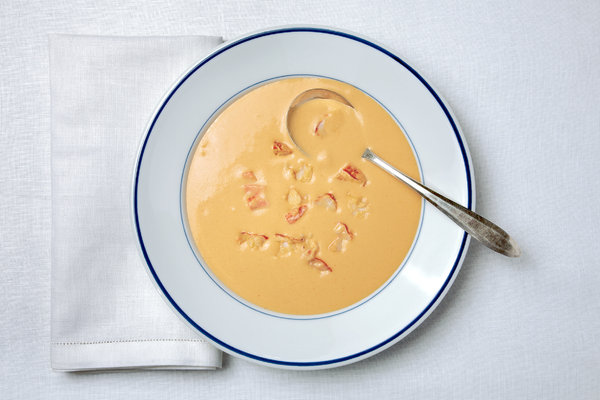

Does this food have a main ingredient? (ie. input "Chicken" for Chicken burrito)
input "no" if it does not have one
The result ranked number 1 was Lobster bisque with probability of 1.0 

The ingredients required to cook this are:
3 tablespoons butter
¼ cup chopped fresh mushrooms
2 tablespoons chopped onion
2 tablespoons chopped celery
2 tablespoons chopped carrot
1 (14.5 ounce) can chicken broth
⅛ teaspoon salt
⅛ teaspoon cayenne pepper
1 ½ cups half-and-half
½ cup dry white wine
½ pound cooked lump lobster meat

The Recipe for a dish like this would be:
Step 1: Melt the butter in a large saucepan over medium-low heat. Add the mushrooms, onion, celery, and carrot. Cook and stir until tender, about 10 minutes. Stir in the chicken broth, and season with salt and cayenne pepper. Bring to a boil, then simmer for 10 minutes
Step 2: Pour the vegetable and broth mixture into the container of a blender, and add 1/4 cup of the lobster meat. Cover, and process until smooth. Return to the sauce

In [67]:
# file_path = 'images/filet-mignon.jpg'
# file_path = 'images/pepperoni_pizza.jpg'
# file_path = 'images/sushi.jpg'
# file_path = 'images/Pho-Beef.jpg'
file_path = 'images/lobster_bisque.jpg'
image = Image.open(file_path).convert('RGB')
display(image)
cleanoutput(findRecipe(predict_food(image, cats, model, preprocess, text_features)))
